In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import math
from sklearn.model_selection import KFold

nltk.download('wordnet')
nltk.download('stopwords')



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
def load_and_merge_csv(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    
    for file in all_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, usecols=['movie_id', 'movie_name', 'description', 'genre'])
        df_list.append(df)
    
    # Concatenate all dataframes
    merged_df = pd.concat(df_list, ignore_index=True).drop_duplicates()
    
    # One-hot encoding of genres
    genre_dummies = merged_df['genre'].str.get_dummies(sep=', ')
    
    # Merge one-hot encoded genres with main dataframe
    final_df = pd.concat([merged_df.drop(columns=['genre']), genre_dummies], axis=1)
    
    return final_df

# Example usage
folder_path = r"C:\Users\abhay\Movie_classification\3"  
final_df = load_and_merge_csv(folder_path)

In [38]:
display(final_df)

movie_id                         movie_name  \
0        tt9114286     Black Panther: Wakanda Forever   
1        tt1630029           Avatar: The Way of Water   
2        tt5884796                              Plane   
3        tt6710474  Everything Everywhere All at Once   
4        tt5433140                             Fast X   
...            ...                                ...   
368291   tt0009655                      Stolen Orders   
368294  tt26684378                            Dalilah   
368296  tt26690183                World War 1 project   
368297  tt26695367                                 74   
368299  tt26733697   Spion 11: Operasjon Traelandsfos   

                                              description  Action  Adult  \
0       The people of Wakanda fight to protect their h...       1      0   
1       Jake Sully lives with his newfound family form...       1      0   
2       A pilot finds himself caught in a war zone aft...       1      0   
3       A middle-aged Chinese immigrant is swept up in...       1      0   
4       Dom Toretto and his family are targeted by the...       1      0   
...                                                   ...     ...    ...   
368291  A renegade American and his innocent daughter ...       0      0   
368294                                         Add a Plot       0      0   
368296                                         Add a Plot       0      0   
368297  74 centres on the lives of four women, and the...       0      0   
368299                                         Add a Plot       0      0   

        Adventure  Animation  Biography  Comedy  Crime  ...  News  Reality-TV  \
0               1          0          0       0      0  ...     0           0   
1               1          0          0       0      0  ...     0           0   
2               0          0          0       0      0  ...     0           0   
3               1          0          0       1      0  ...     0           0   
4               0          0          0       0      1  ...     0           0   
...           ...        ...        ...     ...    ...  ...   ...         ...   
368291          0          0          0       0      0  ...     0           0   
368294          0          0          0       0      0  ...     0           0   
368296          0          0          0       0      0  ...     0           0   
368297          0          0          0       0      0  ...     0           0   
368299          0          0          0       1      0  ...     0           0   

        Romance  Sci-Fi  Short  Sport  Talk-Show  Thriller  War  Western  
0             0       0      0      0          0         0    0        0  
1             0       0      0      0          0         0    0        0  
2             0       0      0      0          0         1    0        0  
3             0       0      0      0          0         0    0        0  
4             0       0      0      0          0         0    0        0  
...         ...     ...    ...    ...        ...       ...  ...      ...  
368291        0       0      0      0          0         0    1        0  
368294        0       0      0      0          0         0    1        0  
368296        0       0      0      0          0         0    1        0  
368297        0       0      0      0          0         0    1        0  
368299        0       0      0      0          0         0    1        0  

[243715 rows x 30 columns]

In [39]:
final_df.shape

(243715, 30)

In [40]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243715 entries, 0 to 368299
Data columns (total 30 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   movie_id     243715 non-null  object
 1   movie_name   243713 non-null  object
 2   description  243715 non-null  object
 3   Action       243715 non-null  int64 
 4   Adult        243715 non-null  int64 
 5   Adventure    243715 non-null  int64 
 6   Animation    243715 non-null  int64 
 7   Biography    243715 non-null  int64 
 8   Comedy       243715 non-null  int64 
 9   Crime        243715 non-null  int64 
 10  Drama        243715 non-null  int64 
 11  Family       243715 non-null  int64 
 12  Fantasy      243715 non-null  int64 
 13  Film-Noir    243715 non-null  int64 
 14  Game-Show    243715 non-null  int64 
 15  History      243715 non-null  int64 
 16  Horror       243715 non-null  int64 
 17  Music        243715 non-null  int64 
 18  Musical      243715 non-null  int64 
 19  Mystery

In [41]:
missing_rows = final_df[final_df['movie_name'].isnull()]
display(missing_rows)

movie_id movie_name  \
14130    tt5774076        NaN   
354393  tt17042812        NaN   

                                              description  Action  Adult  \
14130   Two boys throw a party while their parents are...       1      0   
354393  A survival game show on the web, abandons cont...       0      0   

        Adventure  Animation  Biography  Comedy  Crime  ...  News  Reality-TV  \
14130           0          0          0       0      0  ...     0           0   
354393          0          0          0       0      0  ...     0           0   

        Romance  Sci-Fi  Short  Sport  Talk-Show  Thriller  War  Western  
14130         0       0      0      0          0         0    0        0  
354393        0       0      0      0          0         1    0        0  

[2 rows x 30 columns]

In [42]:
final_df['movie_name'].fillna("Unknown", inplace=True)

C:\Users\abhay\AppData\Local\Temp\ipykernel_3996\1054287886.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df['movie_name'].fillna("Unknown", inplace=True)


In [43]:
final_df = final_df.reset_index(drop=True)

In [45]:
# Check for duplicate movie_id values
duplicate_movie_ids = final_df[final_df.duplicated(subset=['movie_id'], keep=False)]

if duplicate_movie_ids.empty:
    print("All movie_id values are unique. It behaves like a primary key.")
else:
    print(f"Found {len(duplicate_movie_ids)} duplicate movie_id values. It does not behave like a primary key.")
    display(duplicate_movie_ids)  # Display the duplicate rows


Found 1036 duplicate movie_id values. It does not behave like a primary key.


movie_id                                   movie_name  \
560     tt15326988                                      Ghosted   
603      tt8589698  Teenage Mutant Ninja Turtles: Mutant Mayhem   
773      tt0108333                         The Three Musketeers   
1345    tt12965390                            Perfect Addiction   
1493     tt0286112                               Shaolin Soccer   
...            ...                                          ...   
240561   tt0042977                                 The Horsemen   
240602   tt0049180                   Embajadores en el Infierno   
240742   tt0211380                         The Fuhrer Runs Amok   
241294  tt10542800                   Ohi Day - Freedom or Death   
242275   tt0314588                           Roman i Francheska   

                                              description  Action  Adult  \
560                                     Plot under wraps.       1      0   
603     CG-animated feature film based on the superher...       1      0   
773     France, 1625: Young d'Artagnan heads to Paris ...       1      0   
1345    A Successful boxing trainer discovers that her...       1      0   
1493    A young Shaolin follower reunites with his dis...       1      0   
...                                                   ...     ...    ...   
240561  The rival of a worker on a Cossack stud farm e...       0      0   
240602  Spanish right-wingers equally devoted to Catho...       0      0   
240742  France and Germany are at war. Adolf Hitler ch...       0      0   
241294  Dramatic love story in Greece during World War...       0      0   
242275                                         Add a Plot       0      0   

        Adventure  Animation  Biography  Comedy  Crime  ...  News  Reality-TV  \
560             1          0          0       0      0  ...     0           0   
603             1          1          0       0      0  ...     0           0   
773             1          0          0       1      0  ...     0           0   
1345            0          0          0       0      0  ...     0           0   
1493            0          0          0       1      0  ...     0           0   
...           ...        ...        ...     ...    ...  ...   ...         ...   
240561          0          0          0       0      0  ...     0           0   
240602          0          0          1       0      0  ...     0           0   
240742          0          0          0       1      0  ...     0           0   
241294          0          0          0       0      0  ...     0           0   
242275          0          0          0       0      0  ...     0           0   

        Romance  Sci-Fi  Short  Sport  Talk-Show  Thriller  War  Western  
560           1       0      0      0          0         0    0        0  
603           0       0      0      0          0         0    0        0  
773           0       0      0      0          0         0    0        0  
1345          1       0      0      0          0         0    0        0  
1493          0       0      0      0          0         0    0        0  
...         ...     ...    ...    ...        ...       ...  ...      ...  
240561        0       0      0      1          0         0    1        0  
240602        0       0      0      0          0         0    1        0  
240742        0       0      0      1          0         0    1        0  
241294        1       0      0      0          0         0    1        0  
242275        1       0      0      0          0         0    1        0  

[1036 rows x 30 columns]

In [47]:
# Group by 'movie_id', keep the first occurrence of 'movie_name' and 'description'
final_df = final_df.groupby('movie_id', as_index=False).agg({
    'movie_name': 'first',      # Keep first occurrence of movie_name
    'description': 'first',     # Keep first occurrence of description
    **{col: 'max' for col in final_df.columns if col not in ['movie_id', 'movie_name', 'description']}
})

# Check if duplicates are removed
print(final_df['movie_id'].duplicated().sum())  # Should be 0


0


In [48]:
# Check for duplicate movie_id values
duplicate_movie_ids = final_df[final_df.duplicated(subset=['movie_id'], keep=False)]

if duplicate_movie_ids.empty:
    print("All movie_id values are unique. It behaves like a primary key.")
else:
    print(f"Found {len(duplicate_movie_ids)} duplicate movie_id values. It does not behave like a primary key.")
    display(duplicate_movie_ids)  # Display the duplicate rows


All movie_id values are unique. It behaves like a primary key.


In [49]:
final_df.shape

(243197, 30)

In [50]:
# Reset index to ensure proper sequential indexing
final_df = final_df.reset_index(drop=True)

In [53]:
print(final_df.index)  # Should be a range from 0 to (number of rows - 1)
display(final_df.head())  # Display first few rows to confirm

RangeIndex(start=0, stop=243197, step=1)


movie_id                      movie_name  \
0  tt0000009                      Miss Jerry   
1  tt0000574     The Story of the Kelly Gang   
2  tt0000679  The Fairylogue and Radio-Plays   
3  tt0001049                  Gøngehøvdingen   
4  tt0001115                   Ansigttyven I   

                                         description  Action  Adult  \
0  The adventures of a female reporter in the 1890s.       0      0   
1  Story of Ned Kelly, an infamous 19th-century A...       1      0   
2  L. Frank Baum would appear in a white suit and...       0      0   
3                                         Add a Plot       0      0   
4  Consul Bjørn is urgently called to a company m...       0      0   

   Adventure  Animation  Biography  Comedy  Crime  ...  News  Reality-TV  \
0          0          0          0       0      0  ...     0           0   
1          1          0          1       0      0  ...     0           0   
2          1          0          0       0      0  ...     0           0   
3          0          0          0       0      0  ...     0           0   
4          0          0          0       0      1  ...     0           0   

   Romance  Sci-Fi  Short  Sport  Talk-Show  Thriller  War  Western  
0        1       0      0      0          0         0    0        0  
1        0       0      0      0          0         0    0        0  
2        0       0      0      0          0         0    0        0  
3        0       0      0      0          0         0    1        0  
4        0       0      0      0          0         0    0        0  

[5 rows x 30 columns]

In [55]:
# Exclude non-category columns
category_columns = final_df.columns.drop(['movie_id', 'movie_name', 'description'])

# Convert genre columns to category datatype
for col in category_columns:
    final_df[col] = final_df[col].astype('category')


In [58]:
sum_genre = final_df[category_columns].astype(int).sum()

df_movies_per_genre = pd.DataFrame({'Genre': category_columns, 'Total': sum_genre.values})



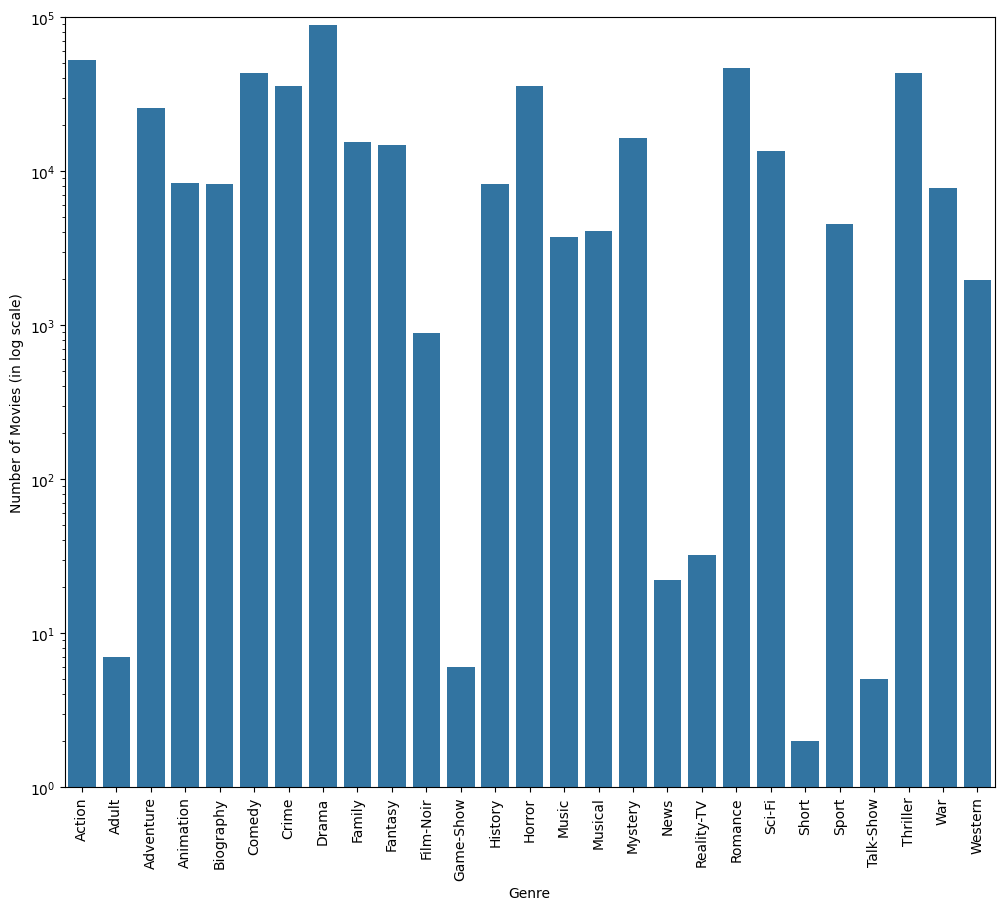

In [60]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', ax=ax)
ax.set(yscale='log', ylim=(1, 1e5), ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()

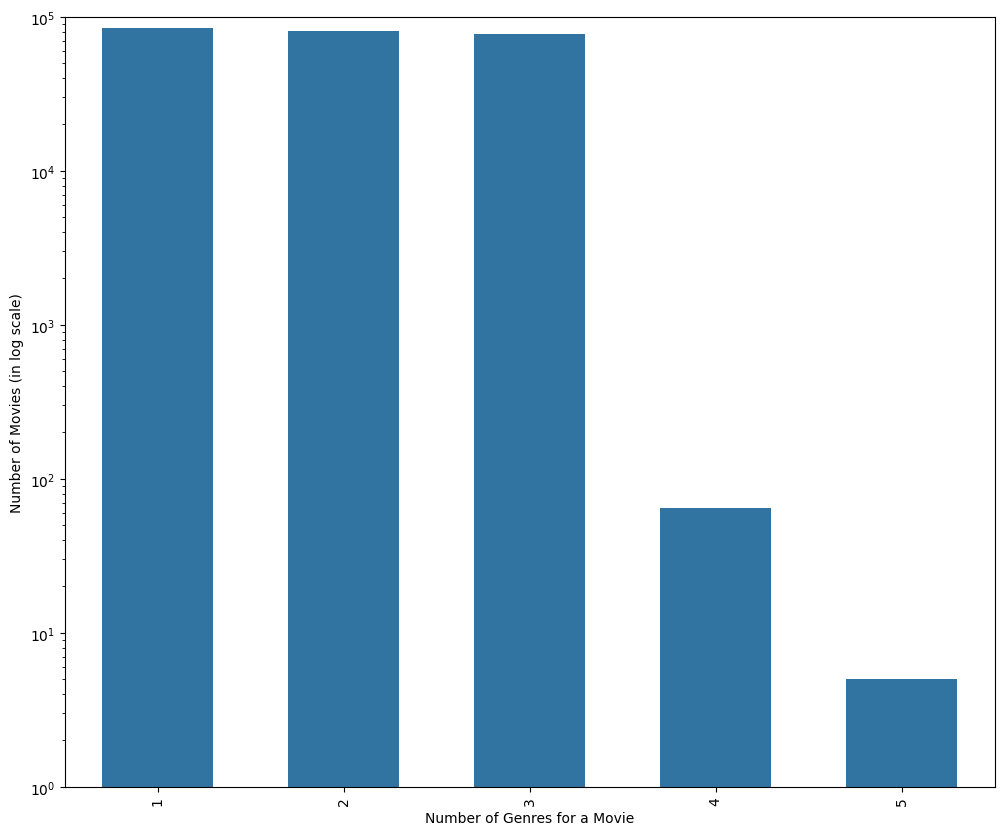

In [63]:
sum_movie = final_df[category_columns].astype(int).sum(axis=1)
df_genres_per_movie = pd.DataFrame({'movie_name': final_df.movie_name, 'num_genres': sum_movie}).groupby('num_genres').count()

f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.barplot(data=df_genres_per_movie, x=df_genres_per_movie.index, y='movie_name', ax=ax, width=0.6)  
ax.set(yscale='log', ylim=(1, 1e5), xlabel='Number of Genres for a Movie', ylabel='Number of Movies (in log scale)')
plt.xticks(rotation=90)
plt.show()


In [66]:
def remove_accents(sentence):
    cleaned_sentence = unicodedata.normalize('NFD', sentence)
    cleaned_sentence = cleaned_sentence.encode('ascii', 'ignore')
    cleaned_sentence = cleaned_sentence.decode("utf-8")
    return cleaned_sentence

In [68]:
def remove_accents(text):
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore').decode("utf-8")
    return text

In [70]:
def remove_punctuation(text):
    text = re.sub(r'[?|!|\'|"|#]', '', text)
    text = re.sub(r'[,|.|;|:|(|)|{|}|\|/|<|>]|-', ' ', text)
    text = text.replace("\n", " ")
    return text

In [71]:
def keep_alpha(text):
    text = re.sub('[^a-zA-Z ]+', ' ', text)
    return text

In [72]:
def lower_case(text):
    return text.lower()

In [74]:
def lemmatize_words(sentence):
    lem = WordNetLemmatizer()
    lemmatized_words = [lem.lemmatize(word, 'v') for word in sentence.split()]
    return ' '.join(lemmatized_words)

In [102]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    stop_words.update(['add','plot','summary','full','see','life','story','life','live','find'])
    no_stop_words = [word for word in sentence.split() if word not in stop_words]
    return ' '.join(no_stop_words)

In [103]:
def text_preprocess(sentence):
    pre_processed_sentence = remove_accents(sentence)
    pre_processed_sentence = remove_punctuation(pre_processed_sentence)
    pre_processed_sentence = keep_alpha(pre_processed_sentence)
    pre_processed_sentence = lower_case(pre_processed_sentence)
    pre_processed_sentence = lemmatize_words(pre_processed_sentence)
    pre_processed_sentence = remove_stop_words(pre_processed_sentence)
    
    return pre_processed_sentence


In [104]:
final_df['description'] = final_df['description'].apply(text_preprocess)

In [105]:
def display_wordcloud_plots(data, labels):
    for col in labels:
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(data[data[col] == 1]['plot']))
        plt.figure(figsize=(9, 9))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f'Movie Genre: {col}')
        plt.show()

def display_wordcloud_subplots(data, labels):
    num_cols = 2
    num_rows = math.ceil(len(labels) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 20))
    axes = axes.flatten()

    for idx, col in enumerate(labels):
        wordcloud = WordCloud(max_font_size=50).generate(' '.join(data[data[col] == 1]['plot']))
        axes[idx].imshow(wordcloud, interpolation="bilinear")
        axes[idx].axis("off")
        axes[idx].set_title(f'Movie Genre: {col}')

    for ax in axes[len(labels):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


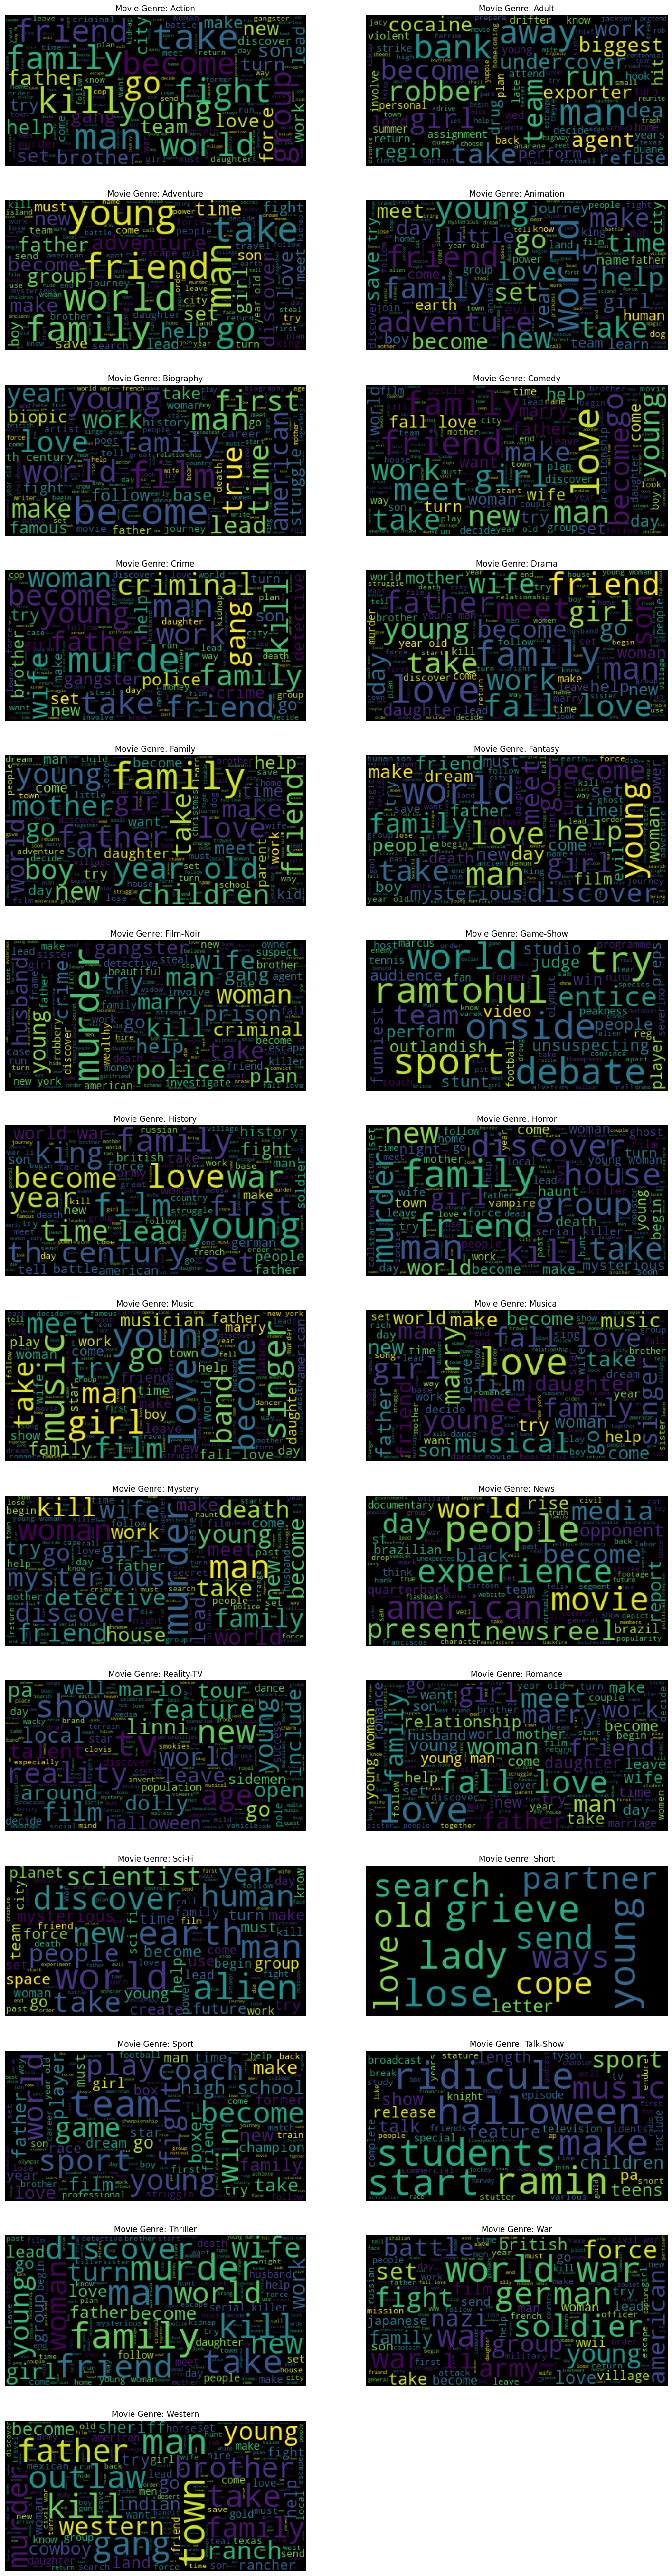

In [106]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import math

fig = plt.figure(figsize=(18, 70))
num_cols = 2
num_rows = math.ceil(len(category_columns) / num_cols)

for idx, col in enumerate(category_columns):
    wordcloud = WordCloud(max_font_size=50).generate(' '.join(final_df[final_df[col] == 1]['description']))
    ax = fig.add_subplot(num_rows, num_cols, idx + 1)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set(title=f'Movie Genre: {col}')

plt.show()


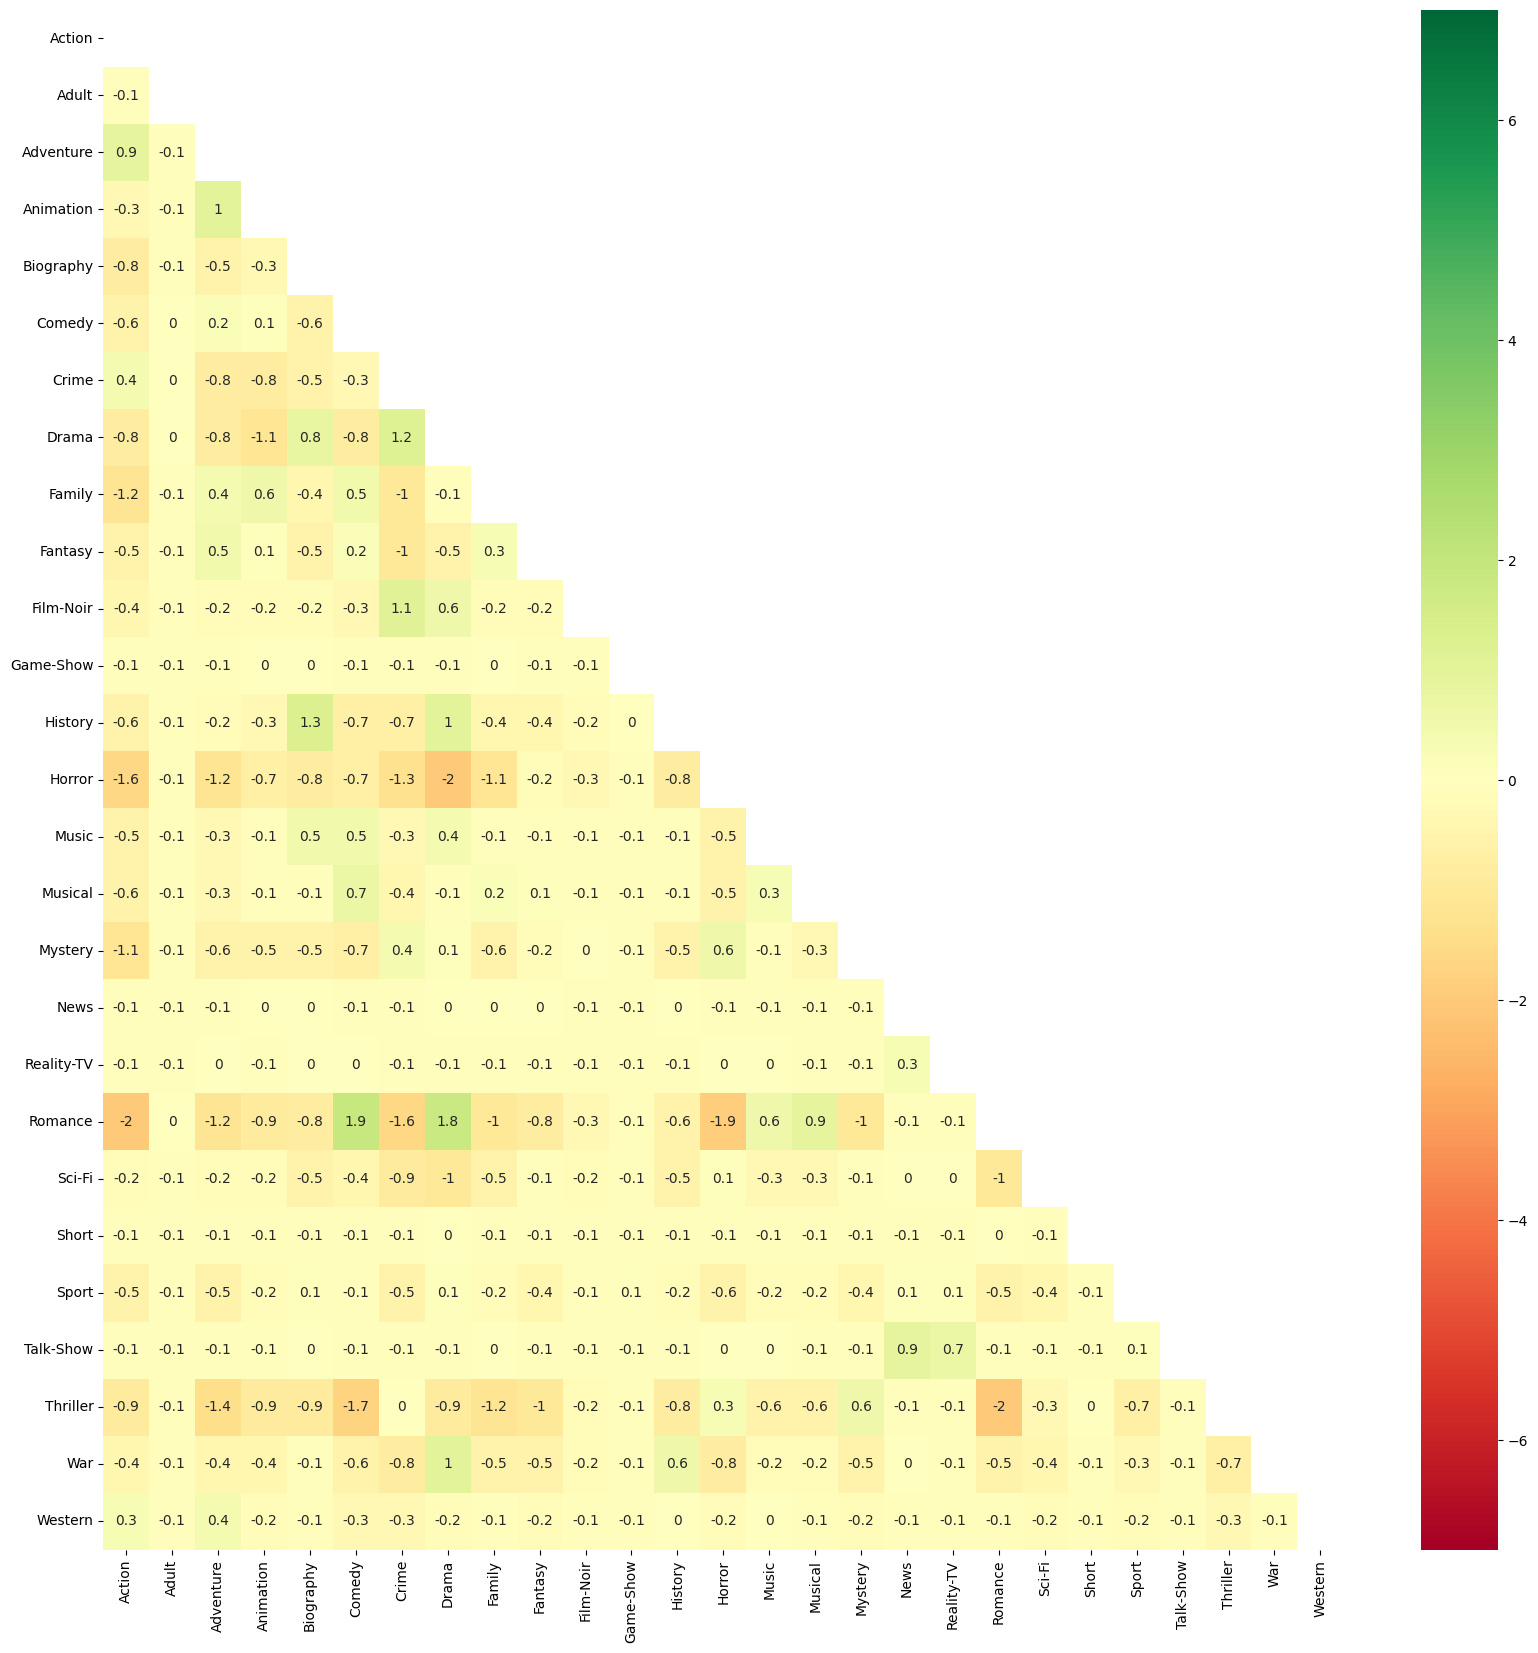

In [108]:
corr_matrix = final_df[category_columns].astype(int).corr()

# Create a mask for the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Scale correlation values for better readability
corr_matrix = (100 * corr_matrix // 1) / 10

# Plot the heatmap
fig = plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, mask=mask, annot=True, cbar=True, vmax=7, vmin=-7, cmap='RdYlGn')

plt.show()

In [300]:
def multi_label_train_test_split(final_df, category_columns, min_test_size=0.15, shuffle=True, random_state=29):
    data_size = final_df.shape[0]
    
    # Boolean mask for test data
    data_test_idx = np.array([False] * data_size)

    # Number of folds
    n_folds = math.floor(1 / min_test_size)
    
    # Track rows to be completely excluded
    exclude_idx = np.array([False] * data_size)

    for col in category_columns:
        # Get all rows where the label is present
        data_curr_genre = final_df[final_df[col] == 1]
        curr_genre_size = data_curr_genre.shape[0]
        
        # Exclude genres with fewer than 10 movies
        if curr_genre_size < 6:
            exclude_idx[data_curr_genre.index] = True
            continue
        
        # Compute test set size for this label
        curr_test_size = math.ceil(curr_genre_size * min_test_size)

        # KFold cross-validation
        kf = KFold(n_splits=min(n_folds, curr_genre_size), shuffle=shuffle, random_state=random_state)
        split_indices = list(kf.split(data_curr_genre))

        # Use the first fold for the test set
        test_indices = split_indices[0][1][:curr_test_size]

        # Map selected test indices to original data
        data_test_idx[data_curr_genre.iloc[test_indices].index] = True

    # Exclude rows belonging to rare genres
    valid_idx = ~exclude_idx

    # Split data into train and test sets, excluding rare genres
    final_test = final_df[data_test_idx & valid_idx]
    final_train = final_df[~data_test_idx & valid_idx]
    
    return final_train, final_test


In [301]:
# Running the function to get train and test datasets
final_train, final_test = multi_label_train_test_split(final_df, category_columns)

# Displaying the sizes of train and test sets
print("Train Data Shape:", final_train.shape)
print("Test Data Shape:", final_test.shape)


Train Data Shape: (178675, 30)
Test Data Shape: (64515, 30)


In [302]:
# Convert categorical columns to integers before summing
sum_genre = final_df[category_columns].astype(int).sum()
sum_genre_train = final_train[category_columns].astype(int).sum()
sum_genre_test = final_test[category_columns].astype(int).sum()

# Creating dataframes for train and test genre distributions
df_movies_per_genre_train = pd.DataFrame({'Genre': category_columns, 'Total': sum_genre_train / sum_genre, 'Data Set': 'Train'})
df_movies_per_genre_test = pd.DataFrame({'Genre': category_columns, 'Total': sum_genre_test / sum_genre, 'Data Set': 'Test'})

# Concatenating both datasets for visualization
df_movies_per_genre = pd.concat([df_movies_per_genre_train, df_movies_per_genre_test])

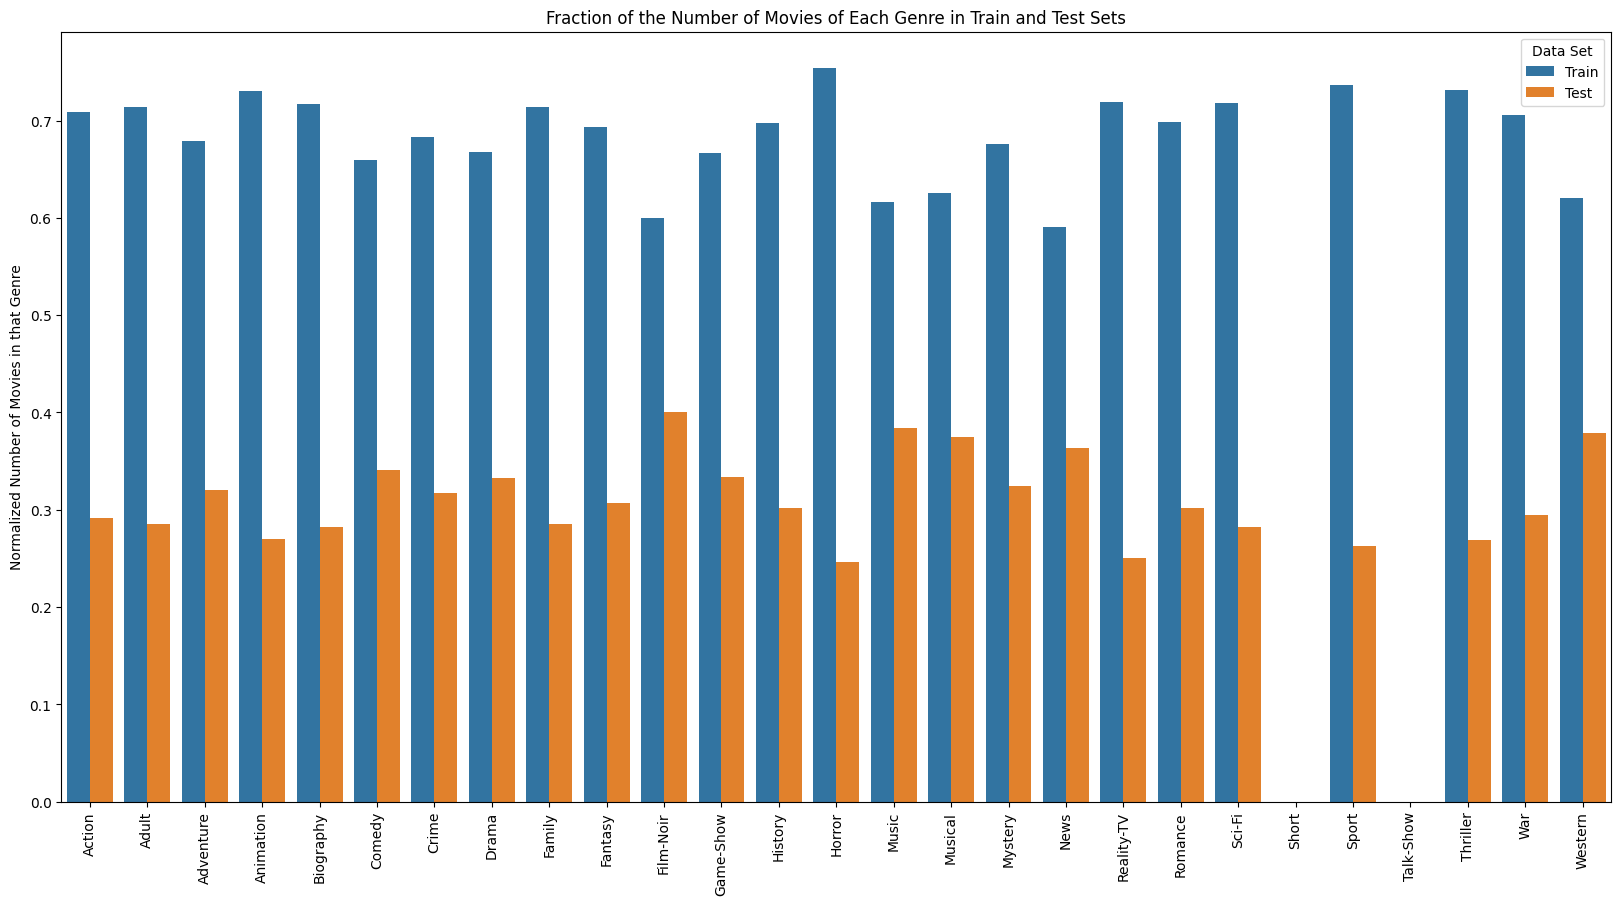

In [303]:
# Plotting the genre distribution in train and test sets
plt.figure(figsize=(20, 10))
sns.barplot(data=df_movies_per_genre, x='Genre', y='Total', hue='Data Set')
plt.ylabel('Normalized Number of Movies in that Genre')
plt.xlabel('')
plt.title('Fraction of the Number of Movies of Each Genre in Train and Test Sets')
plt.xticks(rotation=90)
plt.show()
